In [ ]:
# Requer: pip install numpy scipy
import numpy as np
from scipy.optimize import minimize, Bounds, NonlinearConstraint

# ----------------------------
# Parâmetros do processo
# ----------------------------
N      = 500                # número de passos
dt     = 60.0               # passo de tempo [s]  (60 s = 1 min)
t_end  = N*dt

V0     = 40.0               # volume inicial [L]
V_ref  = 30.0               # volume alvo [L]
T0     = 20.0               # temperatura inicial [°C]
Tb     = 100.0              # temp. de ebulição [°C]
a_gate = 3.0                # inclinação do gate [°C^-1]
beta_h = 0.08               # % por hora (ex.: 0.08 h^-1 = 8%/h)
beta   = beta_h/3600.0      # [s^-1]

rho_mos = 1.00              # kg/L (aprox.)
cp_mos  = 4180.0            # J/(kg.K)
C_rec   = 6.0e4             # J/K (capacitância térmica da caldeira)
rho_w   = 0.958             # kg/L (água ~100°C)
h_fg    = 2.257e6           # J/kg
eta     = 0.85              # eficiência do aquecimento

P_max   = 60000.0            # W (60 kW)
T_min   = 20.0              # °C
T_max   = 102.0             # °C

# Pesos do objetivo
w1 = 1.0
w2 = 1e-6   # peso sobre energia elétrica (ajuste conforme escala desejada)

# ----------------------------
# Funções auxiliares
# ----------------------------
def sigma(T):
    """Gate logístico de ebulição."""
    return 1.0/(1.0 + np.exp(-a_gate*(T - Tb)))

def unpack(x):
    """Converte vetor x -> (P[0..N-1], T[1..N]) mantendo T0 fixo."""
    P = x[:N]
    T = np.empty(N+1)
    T[0] = T0
    T[1:] = x[N:]
    return P, T

def volume_traj(T):
    """Recursão exata do volume: V_{k+1} = V_k * exp(-beta*sigma(T_k)*dt)."""
    V = np.empty(N+1)
    V[0] = V0
    for k in range(N):
        V[k+1] = V[k]*np.exp(-beta * sigma(T[k]) * dt)
    return V

# ----------------------------
# Objetivo
# ----------------------------
def objective(x):
    P, T = unpack(x)
    V = volume_traj(T)
    J = w1*(V[-1] - V_ref)**2 + w2*np.sum(P)*dt
    return J

# ----------------------------
# Restrições de igualdade: balanço de energia por passo
# eta*P_k*dt = (rho*cp*Vbar + C_rec)*(T_{k+1}-T_k) + rho_w*h_fg*(V_k - V_{k+1})
# ----------------------------
def energy_balance_residual(x):
    P, T = unpack(x)
    V = volume_traj(T)
    res = np.empty(N)
    # use Vbar = V_k (simples); pode trocar por 0.5*(V_k+V_{k+1})
    for k in range(N):
        sensible = (rho_mos*cp_mos*V[k] + C_rec)*(T[k+1]-T[k])
        latent   = rho_w*h_fg*(V[k] - V[k+1])
        res[k]   = eta*P[k]*dt - (sensible + latent)
    return res

# nlc = NonlinearConstraint(energy_balance_residual, 0.0, 0.0)

# ----------------------------
# Bounds das variáveis
# x = [P_0..P_{N-1}, T_1..T_N]
# ----------------------------
lb_P = np.zeros(N)
ub_P = np.full(N, P_max)

lb_T = np.full(N, T_min)
ub_T = np.full(N, T_max)

bounds = Bounds(np.concatenate([lb_P, lb_T]),
                np.concatenate([ub_P, ub_T]))

# ----------------------------
# Chute inicial
# ----------------------------
P0 = np.full(N, 0.5*P_max)    # metade da potência
# aquecimento linear até Tb em metade do tempo e depois mantém
T_init = np.linspace(T0, Tb, 20 + 1)
T_hold = np.full(N - (N//2), Tb)
T1N = np.concatenate([T_init[1:], T_hold])  # sem T0
x0 = np.concatenate([P0, T1N])

# ----------------------------
# Otimização
# ----------------------------
result = minimize(objective, x0, method='trust-constr',
                  constraints=[nlc], bounds=bounds,
                  options=dict(verbose=3, maxiter=30))

print("\nStatus:", result.message)
P_opt, T_opt = unpack(result.x)
V_opt = volume_traj(T_opt)
E_grid = np.sum(P_opt)*dt/3600.0/1000.0  # kWh

print(f"V_N = {V_opt[-1]:.3f} L  (alvo {V_ref} L)")
print(f"Energia elétrica ≈ {E_grid:.3f} kWh")
print(f"P médio = {np.mean(P_opt):.1f} W")



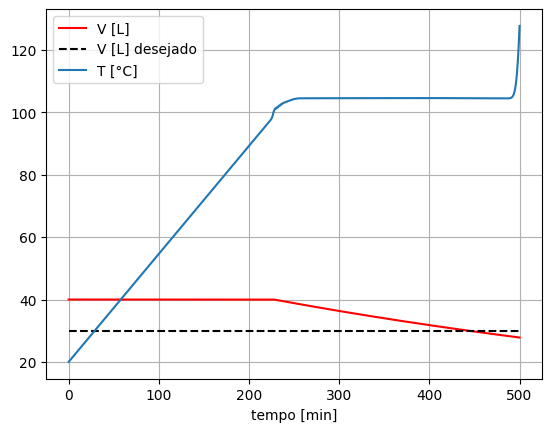

In [ ]:
# %matplotlib inline
# Caso queira ver as três séries:
import matplotlib.pyplot as plt
t = np.arange(N+1)*dt/60.0   # minutos
plt.plot(t, V_opt, color='red', label='V [L]')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.plot(t, T_opt, label='T [°C]')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

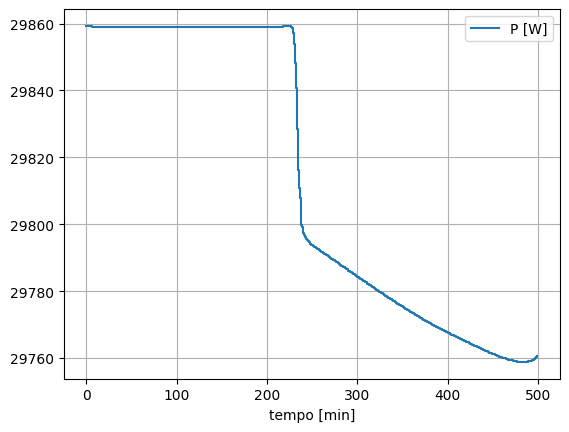

In [ ]:
plt.step(t[:-1], P_opt, where='post', label='P [W]')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize, Bounds, NonlinearConstraint

N, dt = 500, 60.0
V0, T0, V_ref = 40.0, 20.0, 30.0
Tb, a, beta, b = 100.0, 2.0, 0.1/3600.0, 2.0
rho_mos, cp_mos, C_rec = 1.0, 4180.0, 6e4
rho_w, h_fg, eta = 0.958, 2.257e6, 0.85
P_max, T_min, T_max = 6e3, 20.0, 102.0
w1, w2 = 1.0, 0.0
epsilon = 1e-6

def sigma(T): return 1.0/(1.0+np.exp(-a*(T-Tb)))

def sigma_P(P): return P/(P + epsilon)
# def sigma_P(P): return 1.0/(1.0+np.exp(-b*P))

def unpack(x):
    P = x[:N]
    T = np.empty(N+1); T[0]=T0; T[1:] = x[N:N+N]
    V = np.empty(N+1); V[0]=V0; V[1:] = x[N+N:]
    return P, T, V

def objective(x):
    P, T, V = unpack(x)
    # print(V.shape, np.full(N, V_ref).shape)
    return w1*np.sum(V[-30:]-np.full(30, V_ref))**2 + w2*np.sum(P)
    # return w1*(V[-1]-V_ref)**2 + w2*np.sum(P)*dt

# Equality constraints stacked for all k
def volume_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N)
    for k in range(N):
        res[k] = V[k+1] - V[k]*np.exp(-beta*sigma(T[k])*sigma_P(P[k])*dt)
    return res

def energy_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N)
    for k in range(N):
        Vbar = V[k]  # or 0.5*(V[k]+V[k+1])
        sensible = (rho_mos*cp_mos*Vbar + C_rec)*(T[k+1]-T[k])
        latent   = rho_w*h_fg*(V[k]-V[k+1])
        res[k]   = eta*P[k]*dt - (sensible + latent)
    return res

cons = [
    NonlinearConstraint(volume_residual, 0.0, 0.0),
    NonlinearConstraint(energy_residual, 0.0, 0.0),
    # Temperature bounds at all nodes:
    NonlinearConstraint(lambda x: unpack(x)[1],
                        lb=T_min*np.ones(N+1),
                        ub=T_max*np.ones(N+1)),
    # Volume nonnegativity:
    NonlinearConstraint(lambda x: unpack(x)[2],
                        lb=1e-6*np.ones(N+1), ub=np.inf*np.ones(N+1)),
]


# Bounds for decisions: [P_0..P_{N-1}, T_1..T_N, V_1..V_N]
lb = np.concatenate([np.zeros(N),      T_min*np.ones(N),  1e-6*np.ones(N)])
ub = np.concatenate([P_max*np.ones(N), T_max*np.ones(N),  np.inf*np.ones(N)])
bounds = Bounds(lb, ub)

# Feasible initial guess: forward simulate with constant P
P0 = np.full(N, 0.5*P_max)
# simple forward pass to build consistent T,V
Tg = np.empty(N+1); Vg = np.empty(N+1); Tg[0]=T0; Vg[0]=V0
for k in range(N):
    Vg[k+1] = Vg[k]*np.exp(-beta*sigma(Tg[k])*sigma_P(P0[k])*dt)
    Ceff = rho_mos*cp_mos*Vg[k] + C_rec
    Tg[k+1] = Tg[k] + (eta*P0[k]*dt - rho_w*h_fg*(Vg[k]-Vg[k+1]))/Ceff

x0 = np.concatenate([P0, Tg[1:], Vg[1:]])

res = minimize(objective, x0, method='trust-constr',
               bounds=bounds, constraints=cons,
               options=dict(verbose=3, maxiter=50))

print("Status:", res.message)
P_opt, T_opt, V_opt = unpack(res.x)
print(f"V_N={V_opt[-1]:.2f} L, T_max={T_opt.max():.2f} °C, P̄={P_opt.mean():.0f} W")

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   | 1501  |   0   | +8.8543e+04 | 1.00e+00 | 1.34e-01 | 3.74e+02 | 1.00e+00 |  1.00e-01   |   0   |


c:\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|   2   | 3002  |   1   | +8.8543e+04 | 5.83e+00 | 1.34e-01 | 3.74e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   3   | 4503  |   2   | +8.8543e+04 | 3.27e+01 | 1.34e-01 | 5.88e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 6004  |   4   | +8.8543e+04 | 5.28e+01 | 1.39e-01 | 2.10e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 7505  |   6   | +8.8543e+04 | 5.28e+01 | 1.45e-01 | 1.14e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 9006  |   8   | +8.8543e+04 | 5.28e+01 | 1.49e-01 | 6.23e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 10507 |  10   | +8.8543e+04 | 5.28e+01 | 1.50e-01 | 5.16e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   8   | 12008 |  12   | +8.8543e+04 | 5.28e+01 | 1.38e-01 | 3.74e+02 | 1.26e+00 |  1.00e-01   |   4   |
|   9   | 13509 |  15   | +8.8542e+04 | 5.28e+01 | 1.25e-01 | 3.74e+02 | 4.79e+03 |  1.00e-01   |   4   |
|  10   | 15010 |  17   | +8.8527e+04 | 2.96e+02 | 1.25e-01 | 3.74e+02 | 1.43e+06 |  1.00e-01   |   2   |
|  11   | 16511 |  21   | +8.8441e+04 | 1.66e+

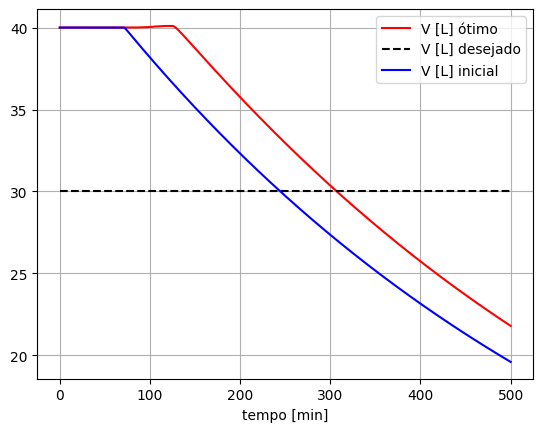

In [2]:
# %matplotlib inline
# Caso queira ver as três séries:
import matplotlib.pyplot as plt
t = np.arange(N+1)*dt/60.0   # minutos
plt.plot(t, V_opt, color='red', label='V [L] ótimo')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.plot(t, Vg, color='blue', label='V [L] inicial')
# plt.plot(t, T_opt, label='T [°C]')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

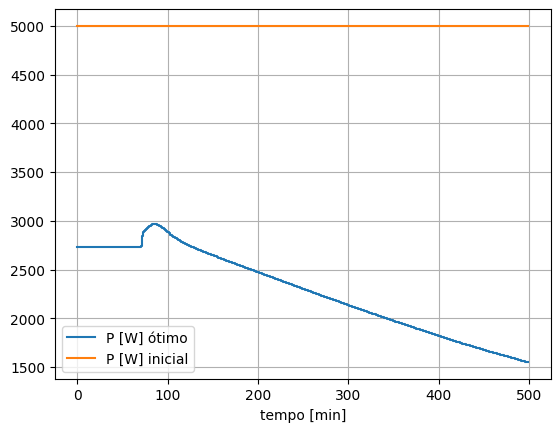

In [3]:
plt.step(t[:-1], P_opt, where='post', label='P [W] ótimo')
plt.step(t[:-1], P0, where='post', label='P [W] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()


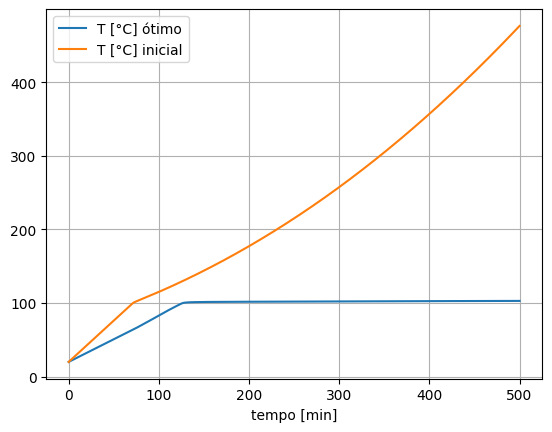

In [4]:
plt.plot(t, T_opt, label='T [°C] ótimo')
plt.plot(t, Tg, label='T [°C] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()